In [48]:
# Variables for configuration
generate_pandas_profiling_reports = False
process_preprocessed_data_of_uci = False
print_pair_plots = False
drop_correlated_features = False
drop_nan= True
encode_labels = True
minimumPercentageMissingToBeDropped = 12
oneHotEncodedFeatures = ['cp','restecg']

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

# set pandas to show all columns of the df when using the display function
pd.set_option('display.max_columns', None)

In [50]:
# list the datasets that should be used in the current run
datasets = ["hungarian", "cleveland", "switzerland", "long-beach-va"]

In [51]:
# custom function to read the dataset into a csv formated string
# the name is used as a delimiter here because it is the last feature and common among all entrys 
def readRawData(filePath:str):
    with open(filePath) as file:
        dataString = file.read()
        dataString = dataString.replace("\n"," ")
        dataString = re.sub("[a-zA-Z]+ ","name\n", dataString)
        dataString = dataString.replace(" ",",")
        return dataString

In [52]:
# read the data from the specified datasets into the df 
from io import StringIO
df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ dataset +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    df = pd.concat([df,dataset_df ], ignore_index=True)

In [53]:
df.columns=["id", "ccf", "age", "sex", "painloc", "painexer" , "relrest" , "pncaden" , "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "dataset"]

In [54]:
# read the data from the specified datasets into the df
from io import StringIO
dfNew = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ 'new' +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    dfNew = pd.concat([dfNew,dataset_df ], ignore_index=True)

In [55]:
df = df.replace(-9, float('nan'))
df.describe()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk
count,899.000000,899.0,899.000000,899.000000,617.000000,617.000000,613.000000,0.0,899.000000,840.000000,865.000000,869.000000,230.000000,479.000000,467.000000,809.000000,95.000000,477.000000,897.000000,846.000000,845.000000,846.000000,831.000000,833.000000,834.000000,836.000000,817.000000,787.000000,843.000000,446.000000,794.000000,844.000000,843.000000,836.000000,836.000000,840.000000,840.000000,844.000000,841.000000,837.000000,591.000000,474.000000,757.000000,291.000000,0.0,1.0,28.000000,30.000000,2.000000,5.000000,422.000000,130.000000,44.000000,1.0,888.000000,890.000000,890.000000,899.000000,624.000000,663.000000,653.000000,341.000000,664.000000,332.000000,628.000000,327.000000,654.000000,629.000000,880.000000,880.000000,880.000000,880.000000,883.000000,311.000000,119.000000
mean,957.235818,0.0,53.480534,0.790879,0.920583,0.593193,0.672104,NaN,3.253615,132.101190,0.476301,198.759494,0.517391,19.118998,18.796574,0.166873,0.957895,0.563941,0.603122,5.973995,15.493491,84.056738,0.034898,0.283313,0.266187,0.172249,0.112607,37.081321,8.655872,5.690359,16.483123,137.298578,75.487544,171.641148,87.293062,132.101190,83.523810,0.390995,0.026159,0.870490,1.766497,14.398734,54.914135,0.697595,NaN,0.0,0.531071,1.033333,0.550000,0.200000,5.018957,1.284615,0.295455,0.0,6.122748,15.988764,83.839326,1.129032,1.323718,1.327300,1.248086,1.202346,1.296687,1.114458,1.176752,1.067278,1.342508,1.171701,1.020455,1.032955,1.132955,1.611364,1.178935,27.623119,5.869748
std,1204.015482,0.0,9.435894,0.406908,0.270607,0.491637,0.469830,NaN,0.928499,19.151127,0.499727,111.834415,0.500787,18.296273,16.359145,0.373093,0.201895,0.496415,0.803669,3.486479,8.761939,1.640204,0.183631,0.870965,0.442228,0.377823,0.316306,50.144559,3.746617,3.994673,30.772801,25.965959,14.727961,25.734488,14.734586,19.151127,10.252563,0.488263,0.159704,1.080548,0.621339,5.702942,60.309425,1.052728,NaN,NaN,0.146195,1.066200,0.070711,0.447214,1.949388,0.958314,0.461522,NaN,3.474114,8.860872,4.407533,1.259720,6.447542,0.469582,0.432233,0.402339,0.457142,0.318847,0.381762,0.250887,0.474912,0.377421,0.277384,0.415902,0.703837,1.722199,0.512572,31.675295,1.650914
min,1.000000,0.0,28.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,60.000000,37.000000,84.000000,11.000000,0.000000,0.000000,0.000000,0.000000,-2.600000,0.000000,2.000000,2.000000,0.000000,NaN,0.0,0.220000,0.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.220000,3.300000
25%,116.000000,0.0,47.000000,1.000000,1.000000,0.000000,0.000000,NaN,3.000000,120.000000,0.000000,175.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,8.000000,83.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,3.000000,5.000000,120.000000,65.000000,155.000000,80.000000,120.000000,80.000000,0.000000,0.000000,0.000000,1.000000,10.000000,12.000000,0.000000,NaN,0.0,0.407500,0.000000,0.525000,0.000000,3.000000,0.000000,0.000000,0.0,3.000000,8.000000,83.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.685000,4.800000
50%,266.000000,0.0,54.000000,1.000000,1.000000,1.000000,1.

In [56]:
# the dataset encodes unfilled cells with -9 they are replaced with NaN for better compatibility with pd
dfNew = dfNew.replace(-9, float('nan'))
dfNew.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88
count,6164.000000,6.140000e+03,6164.000000,6164.000000,4380.000000,3088.000000,3048.000000,4772.000000,6160.000000,5932.000000,5988.000000,5364.000000,1604.000000,2604.000000,2568.000000,5796.000000,6164.000000,2680.000000,6156.000000,5572.000000,5552.000000,5572.000000,5444.000000,5452.000000,5440.000000,5456.000000,5276.000000,5332.000000,5944.000000,3548.000000,5564.000000,5560.000000,5552.000000,5516.000000,5496.000000,5532.000000,5528.000000,5536.000000,5528.000000,5532.000000,4552.000000,1928.000000,1928.000000,1236.000000,0.0,0.0,248.00000,244.000000,16.000000,24.000000,1596.000000,248.000000,72.000000,0.0,4180.000000,4188.000000,4176.000000,6164.000000,4104.000000,4320.000000,4264.000000,2896.000000,4300.000000,2836.000000,4136.000000,2816.000000,4240.000000,4180.000000,5124.000000,5120.000000,5116.000000,5120.000000,6008.000000,1828.000000,484.000000,5948.000000,168.000000,148.000000,668.000000,0.0,0.0,364.000000,0.0,0.0,348.000000,5960.000000,5960.000000,5960.000000,5960.000000
mean,1492.621025,3.233929e+06,52.684620,0.780662,0.903196,0.563472,0.656168,-8.572506,3.158442,131.265678,0.476286,246.902961,0.458853,21.026114,20.724299,0.205659,0.120052,0.580597,0.619883,6.066045,15.582133,1985.668342,0.036738,0.261189,0.319853,0.231672,0.085671,55.421605,8.339401,4.415333,6.477490,136.428058,78.003602,173.698332,90.783843,131.104121,83.101302,0.338150,0.019537,0.844541,1.225835,14.462656,14.168050,0.676375,NaN,NaN,47.66129,1.393443,42.750000,0.666667,4.949875,1.274194,0.555556,NaN,6.135885,15.639924,1984.825670,1.136275,0.295322,0.905556,0.611632,0.122928,0.828837,-0.169252,0.525145,-0.103693,0.935849,0.564593,1.008587,1.049219,1.261923,1.996875,1.253662,62.375274,5.772727,0.121049,5.119048,15.378378,85.532934,NaN,NaN,12.087912,NaN,NaN,1.620690,0.063087,0.021477,0.030201,0.003356
std,830.729269,6.490264e+06,9.801427,0.413832,0.295724,0.496035,0.475064,14.035258,0.954677,17.924989,0.499479,59.934668,0.498459,18.922514,16.344566,0.404217,0.325049,0.493553,0.778522,3.474132,8.733432,2.325940,0.188134,0.439323,0.466462,0.421939,0.279904,52.725321,4.506424,4.277888,2.893518,24.390956,15.725234,26.607772,14.846667,17.868744,9.751158,0.473123,0.138415,1.091111,0.926649,5.715596,5.704247,0.934516,NaN,NaN,15.66444,1.137157,13.213629,1.129319,1.947909,0.955179,0.500391,NaN,3.584378,8.829530,2.194445,1.278228,1.060453,1.240053,1.228795,1.251767,1.263036,1.031216,1.182642,1.127994,1.305310,1.186544,0.121496,0.385211,1.004878,2.151516,0.633326,15.574732,1.795739,0.340339,4.101715,9.628052,5.091999,NaN,NaN,29.686943,NaN,NaN,10.613722,0.243140,0.144979,0.171155,0.057836
min,1.000000,0.000000e+00,20.000000,0.000000,0.000000,0.000000,0.000000,-27.000000,1.000000,80.000000,0.000000,63.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1981.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,69.000000,37.000000,84.000000,26.000000,80.000000,50.000000,0.000000,0.000000,-3.000000,0.000000,2.000000,2.000000,0.000000,NaN,NaN,21.00000,0.000000,29.000000,0.000000,1.000000,0.000000,0.000000,NaN,1.000000,1.000000,1980.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,8.000000,0.000000,0.000000,1.000000,1.000000,59.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1089.000000,2.113000e+03,45.000000,1.000000,1.000000,0.000000,0.000000,-27.000000,2.000000,120.000000,0.000000,209.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,1984.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.500000,0.000000,5.000000,120.000000,66.000000,158.000000

# Data cleanup

In [57]:
if generate_pandas_profiling_reports:
    from pandas_profiling import ProfileReport
    profile = ProfileReport(df, title='Pandas Profiling Report for all features')
    profile.to_file("Pandas Profiling Report for all features.html")

The columns smoke and years both describe whether a respondent smokes or not. Smoke does this by being binary coded, while years describes the number of years a person has smoked. Due to the high number of missing values, the columns are useless on their own. However, it is possible to enrich the smoke column with the years column. 

In [58]:
print(f"Number of NaNs in smoke: {df['smoke'].isna().sum()}")
df.loc[(df['smoke'].isna()) & (df['years'] == 0),'smoke'] = 0
df.loc[(df['smoke'].isna()) & (df['years'] > 0),'smoke'] = 1
print(f"Number of NaNs in smoke after combination with years: {df['smoke'].isna().sum()}")
df.loc[(df['smoke'].isna()) & (df['cigs'] == 0),'smoke'] = 0
df.loc[(df['smoke'].isna()) & (df['cigs'] > 0),'smoke'] = 1
print(f"Number of NaNs in smoke after combination with years and cigs: {df['smoke'].isna().sum()}")

Number of NaNs in smoke: 671
Number of NaNs in smoke after combination with years: 391
Number of NaNs in smoke after combination with years and cigs: 389


Finding: reduces the number of missing values in smoke by 280 entries.

In [59]:
# if cholesterin is 0 it was not measured
df['chol'] = df['chol'].replace(0, float('nan'))

## Explore how many NaNs and zeros are within one column for each attribute.

In [60]:
(df.loc[ : , df.columns != 'dataset'].isna()).join(df['dataset']).groupby("dataset").sum()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,0,0,0,282,282,282,282,0,0,0,0,4,5,5,0,259,0,0,0,0,0,2,2,2,2,2,0,0,69,0,0,0,0,0,0,0,0,0,0,0,282,0,2,282,282,282,282,282,282,2,282,282,282,0,0,0,0,0,0,0,282,0,282,0,282,0,0,0,0,0,0,0,282,282,0
hungarian,1,1,1,1,1,1,1,295,1,2,2,24,283,294,295,9,274,294,2,1,1,1,2,3,2,2,2,10,3,191,3,2,2,2,2,2,2,2,3,1,191,2,1,291,295,295,295,292,295,293,267,268,278,295,1,1,1,1,276,237,247,277,236,286,272,290,245,270,1,1,1,1,1,267,295,1
long-beach-va,1,1,1,1,1,1,5,201,1,57,4,57,2,11,13,8,158,9,1,53,54,53,61,61,60,60,74,54,54,161,54,54,55,60,60,57,57,54,54,57,102,66,66,199,201,200,173,174,199,198,160,170,200,200,3,1,1,1,1,1,1,1,1,1,1,2,2,2,3,3,3,3,4,24,82,1
switzerland,0,0,0,0,0,0,0,123,0,2,30,123,100,112,121,75,115,121,1,1,1,1,5,2,3,1,6,50,1,34,50,1,1,3,3,2,2,1,3,6,17,77,77,118,123,123,123,123,123,123,50,51,97,123,9,9,9,0,0,0,0,0,0,0,0,0,0,0,17,17,17,17,13,17,123,0


In [61]:
(df.loc[ : , df.columns != 'dataset'].eq(0)).join(df['dataset']).groupby("dataset").sum()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,282,0,91,0,0,0,0,0,0,108,0,115,115,115,240,0,107,138,0,0,0,271,186,211,252,248,0,0,43,0,0,0,0,0,0,0,190,276,91,0,0,0,166,0,0,0,0,0,0,0,0,0,0,0,0,0,157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
hungarian,0,294,0,81,23,164,141,0,0,0,195,0,10,0,0,266,0,1,235,0,0,0,293,274,265,269,290,0,0,0,0,0,0,0,0,0,0,204,291,189,0,0,0,3,0,0,0,3,0,2,0,6,7,0,0,0,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
long-beach-va,0,200,0,6,15,65,33,0,0,1,90,0,96,38,38,125,4,100,80,0,0,0,122,88,61,105,94,0,0,2,0,0,0,0,0,1,1,52,139,40,1,0,0,2,0,1,0,10,0,2,0,9,1,1,0,0,0,51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
switzerland,0,123,0,10,11,22,27,0,0,0,60,0,5,0,0,43,0,0,85,0,0,0,116,70,75,66,93,0,0,25,0,0,0,0,0,0,0,68,113,42,0,0,0,0,0,0,0,0,0,0,0,21,23,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Treatment of different scales in the datasets
### met

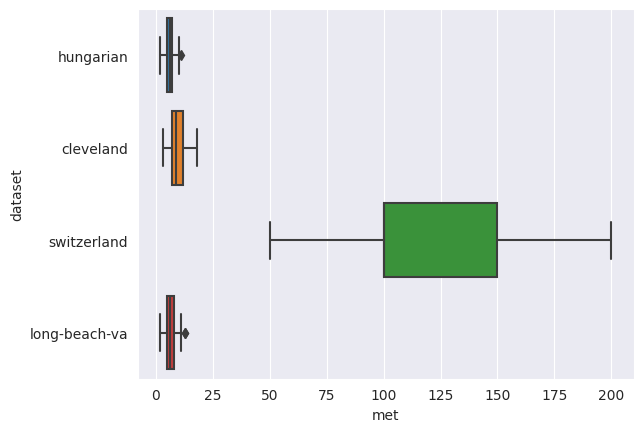

In [62]:
# plot to show the reason why we need to process this data:
sns.boxplot(x="met",y="dataset",data= df)
plt.show()

In [63]:
df.loc[df["dataset"] == "switzerland", "met"] = df.loc[df["dataset"] == "switzerland", "met"]/10

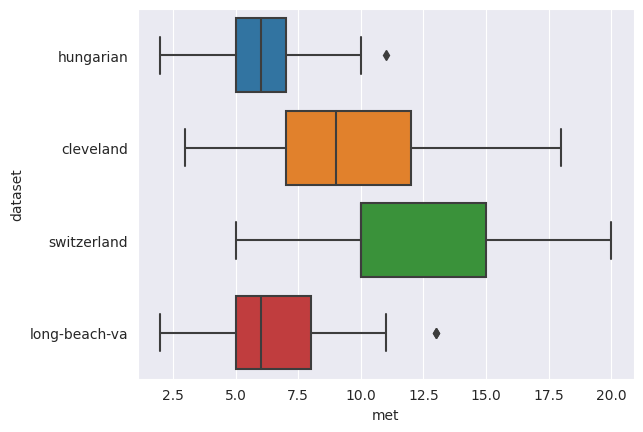

In [64]:
# plot to show the reason why we need to process this data:
sns.boxplot(x="met",y="dataset",data= df)
plt.show()

### rldv5e

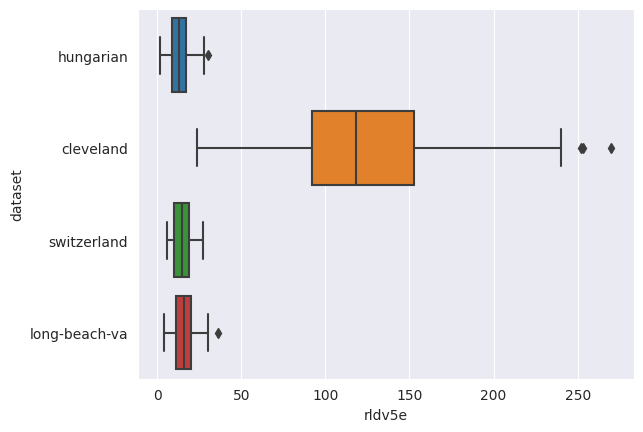

In [65]:
# plot to show the reason why we need to process this data: 
sns.boxplot(x="rldv5e",y="dataset",data= df)
plt.show()

In [66]:
df.loc[df["dataset"] == "cleveland", "rldv5e"] = df.loc[df["dataset"] == "cleveland", "rldv5e"]/10

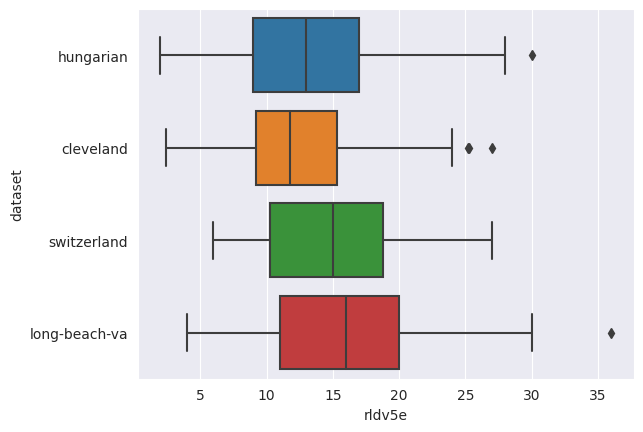

In [67]:
# plot to show the reason why we drop:
sns.boxplot(x="rldv5e",y="dataset",data= df)
plt.show()

In [68]:
# plt.figure(figsize=(15,15))
# # Compute the correlation matrix
# corr = df.corr()
# corr = corr.round(2)
# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1, annot=True)
# plt.show()

In [69]:
# for dataset in datasets:
#     plt.figure(figsize=(15, 15))
#     # Compute the correlation matrix
#     corr = df[df['dataset'] == dataset].corr()
#     corr = corr.round(2)
#     # Draw the heatmap with the mask and correct aspect ratio
#     sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1, annot=True)
#     plt.show()


In [70]:
if drop_correlated_features:
    df.drop("met", inplace=True, axis=1)

# Drop columns

In [71]:
irrelevant_columns = [
    "id", # A id is not relevant for a model
    "ccf", # the social security number does not influence if you have a heart disease or not
    "pncaden", # sum of painlox painexer relrest -> the features are already in the dataset -> drop because it is a duplicate
    "ekgmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "name" # Constant
]
df.drop(irrelevant_columns, inplace=True, axis=1)

In [72]:
unexplained_columns = [
    "restckm", # irrelevant according to the uci
    "exerckm", # irrelevant according to the uci
    "thalsev", # irrelevant according to the uci
    "thalpul", # irrelevant according to the uci
    "earlobe", # Constant
    "lvx1", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx2", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx3", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx4", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvf", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "dummy", # no description available -> from the name does not seem relevant
]
df.drop(unexplained_columns, inplace=True, axis=1)

In [73]:
percentage_missing = ((df.isna().sum()/len(df)*100).round(2)).to_dict()
missing_vlaues = {key: val for key, val in percentage_missing.items() if val > minimumPercentageMissingToBeDropped}
df.drop([*missing_vlaues.keys()], inplace=True, axis=1)

In [74]:
df['dataset'].value_counts()

hungarian        295
cleveland        282
long-beach-va    201
switzerland      123
Name: dataset, dtype: int64

## drop by rows because of unrealistic values

In [75]:
# leave the dead ones behind
# drop entries with a blood pressure of 0
print(f"Shape before drop of entrys with a blood preasure of 0: {df.shape}")
df.drop(df[df['trestbps'] == 0].index, inplace=True, axis=0)
print(f"Shape after drop of entrys with a blood preasure of 0: {df.shape}")

Shape before drop of entrys with a blood preasure of 0: (901, 24)
Shape after drop of entrys with a blood preasure of 0: (900, 24)


In [76]:
# drop entries with unrealistic values for prop
print(f"Shape before drop of entries with unrealisic prop values: {df.shape}")
df.drop(df[df['prop'] > 1].index, inplace=True, axis=0)
print(f"Shape after drop of entries with unrealisic prop values: {df.shape}")

Shape before drop of entries with unrealisic prop values: (900, 24)
Shape after drop of entries with unrealisic prop values: (899, 24)


# drop more columns because switzerland would be lost

In [77]:
# what would happen
df.dropna(axis=0, how='any').loc[:,"dataset"].value_counts()

cleveland        280
hungarian        277
long-beach-va    111
switzerland       44
Name: dataset, dtype: int64

In [78]:
# because of which features
(df.loc[ : , df.columns != 'dataset'].isna()).join(df['dataset']).groupby("dataset").sum()

,age,sex,cp,trestbps,htn,fbs,restecg,dig,prop,nitr,pro,diuretic,thaldur,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,num
dataset,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,0,0,0,0,0,0,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0
hungarian,1,1,1,2,2,9,2,2,3,2,2,2,3,3,2,2,2,2,2,2,3,1,1
long-beach-va,1,1,1,57,4,8,1,61,61,60,60,73,54,54,54,55,60,60,57,54,54,57,1
switzerland,0,0,0,2,30,75,1,5,2,3,1,6,1,50,1,1,3,3,2,1,3,6,0


In [79]:
# df.drop(["fbs", "rldv5e", "htn"], inplace=True, axis=1)

In [80]:
# what would happen now
df.dropna(axis=0, how='any').loc[:,"dataset"].value_counts()

cleveland        280
hungarian        277
long-beach-va    111
switzerland       44
Name: dataset, dtype: int64

## summary

In [81]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df, title='Pandas Profiling Report for selected features')
    profile.to_file("Pandas Profiling Report for selected features.html")

In [82]:
if drop_nan:
    # drop all entries which contain one or more NanN vlaues
    print(f"Shape before drop of NaN containing rows: {df.shape}")
    df.dropna(inplace=True, axis=0, how='any')
    print(f"Shape after drop of NaN containing rows: {df.shape}")

Shape before drop of NaN containing rows: (899, 24)
Shape after drop of NaN containing rows: (712, 24)


In [83]:
df['dataset'].value_counts()

cleveland        280
hungarian        277
long-beach-va    111
switzerland       44
Name: dataset, dtype: int64

# Visualize Data

In [84]:
if print_pair_plots:
    sns.pairplot(df, hue="num", palette="tab10")

In [85]:
if print_pair_plots:
    sns.pairplot(df, hue="dataset", palette="tab10")

In [86]:
from sklearn.preprocessing import LabelEncoder
# drop all rows where the label column is nan
df = df[df['num'].notna()]
if encode_labels:
    labelEncoder = LabelEncoder()
    df.loc[df['num'] >= 1,"num"] = 1
    df['num'] = labelEncoder.fit_transform(df['num'])

In [87]:
if print_pair_plots:
    sns.pairplot(df, hue="num", palette="tab10")

# Train the different models

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from  sklearn.naive_bayes import *

estimators_and_hyperparameters=[
    # {"estimator": CatBoostClassifier(random_state=42, thread_count=-1, silent= True), "parameters": {'classification__depth':[None] + [*range(1,200)],
    #                                                                                                  'classification__n_estimators':range(10,1000, 100),
    #                                                                                                  'classification__learning_rate':[0.001,0.01,0.1,0.2,0.3],
    #                                                                                                  'classification__l2_leaf_reg':range(5,100, 5),
    #                                                                                                  'classification__border_count':range(5,200, 5),
    #                                                                                                  'classification__ctr_border_count':range(5,200, 5)
    #                                                                                                  }},
    # {"estimator": XGBClassifier(random_state=42, n_jobs=1), "parameters": {'classification__max_depth': [None] + [*range(1,200)],
    #                                                                        'classification__n_estimators': range(10,1000, 100),
    #                                                                         'classification__learning_rate':[0.001,0.01,0.1,0.2,0.3]}},
    # {"estimator": SVC(random_state=42, tol=0.01), "parameters": {'classification__C': [110,120,130,140,150],
    #                                                              'classification__gamma': [0.0001, 0.001, 0.01, 0.1],
    #                                                              'classification__degree': [3,4,5,6],
    #                                                              'classification__kernel':['linear', 'rbf', 'poly', 'sigmoid'] }}, # '
    # {"estimator": BernoulliNB(), "parameters": {'classification__alpha' : np.arange(0,20,0.001)}},
    {"estimator": CategoricalNB(), "parameters": {'classification__alpha' : np.arange(0,20,0.001)}},
    # {"estimator": ComplementNB(), "parameters": {'classification__alpha' : np.arange(0,20,0.001),
    #                                              'classification__norm':[True,False]}},
    # {"estimator": GaussianNB(), "parameters": {}},
    # {"estimator": MultinomialNB(), "parameters": {'classification__alpha' : np.arange(0,20,0.001)}},
    # {"estimator": DecisionTreeClassifier(random_state=42), "parameters": {'classification__criterion':['gini','entropy', 'log_loss'],
    #                                                                       'classification__max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
    #                                                                       'classification__min_samples_split': range(2,20),
    #                                                                       'classification__min_samples_leaf': range(2,20)}},
    # {"estimator": KNeighborsClassifier(), "parameters": {'classification__n_neighbors': range(2, 100),
    #                                                      'classification__weights': ['uniform','distance'],
    #                                                      'classification__p': [1,2]}},
    # {"estimator": RandomForestClassifier(random_state=42, n_jobs=1), "parameters": {'classification__n_estimators':range(10,1000, 100),
    #                                                                                 'classification__max_depth':[None] + [*range(1,200)],
    #                                                                                 'classification__min_samples_split':range(2,20),
    #                                                                                 'classification__min_samples_leaf': range(2,20),}},
    # {"estimator": SGDClassifier(max_iter=1000000), "parameters": {'classification__loss':['log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    #                                               'classification__penalty':['l1','l2','elasticnet'],
    #                                               'classification__alpha' : np.arange(1,40,1)}}
]

In [89]:
from sklearn.preprocessing import *
scalers = [
    # {"scaler": MaxAbsScaler(), "parameters": {}},
    {"scaler": MinMaxScaler(), "parameters": {}},
    # {"scaler": Normalizer(), "parameters": {}},
    {"scaler": PowerTransformer(), "parameters": {}},
    {"scaler": RobustScaler(), "parameters": {}},
    {"scaler": FunctionTransformer(lambda x: x), "parameters": {}},
    {"scaler": StandardScaler(), "parameters": {'preprocessing__scaler__with_mean': [ True, False],'preprocessing__scaler__with_std': [ True, False]}}
]

In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset') ]
y = df.loc[: , (df.columns== 'num')].values.ravel()

In [91]:
# assumption the dictionarys are of equal structure
def merge_dict(dict1, dict2):
    for key, val in dict1.items():
        if type(val) == dict:
                merge_dict(dict1[key], dict2[key])
        elif(type(val) == list):
            dict1[key] += (';' + str(dict2[key]))
        else:
            dict1[key] = str(val) + ';'+ str(dict2[key])

    return dict1

In [92]:
import pickle
import os
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


def classification_report_with_accuracy_score(y_true, y_pred):
    confusion_matrix_dict = {}
    for idxRow, row in np.ndenumerate(confusion_matrix(y_true, y_pred)):
        confusion_matrix_dict[idxRow] = row
    current_auc_score = roc_auc_score(y_true, y_pred)
    if os.path.exists('temp.pickle'):
        with open("temp.pickle", "rb") as tempFile:
            report = pickle.load(tempFile)
            report['classification_report'] = merge_dict(report['classification_report'], classification_report(y_true, y_pred, output_dict=True))
            report["auc"].append(current_auc_score)
            report['confusion_matrix'] = merge_dict(report['confusion_matrix'], confusion_matrix_dict)
    else:
        report = {'classification_report': classification_report(y_true, y_pred, output_dict=True)}
        report["auc"] = [current_auc_score]
        report['confusion_matrix'] = confusion_matrix_dict
    with open('temp.pickle', 'wb') as tempFile:
        pickle.dump(report, tempFile, protocol=pickle.HIGHEST_PROTOCOL)


    # because we need to return something
    return current_auc_score # return accuracy score

In [93]:
import time
from sklearn.metrics import make_scorer
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# build pipelines
# create the pipeline
pipelines = []

for scaler in scalers:
    print(f"Scaler: {scaler.get('scaler').__class__.__name__}")
    for estimator in estimators_and_hyperparameters:
        startTime = time.time()

        parameters = scaler.get("parameters") | estimator.get("parameters")
        preprocessor = ColumnTransformer(
            transformers=[
                # use StandardScaler for Temperature and Humidity
                ('scaler', scaler.get("scaler"), X.columns),
                # use OneHotEncoder for Outlook and Wind
                ('encoder', OneHotEncoder(), oneHotEncodedFeatures)
            ])
        pipeline = Pipeline(steps=[ ('preprocessing', preprocessor), ('classification', estimator.get("estimator")) ])
        # create the grid search instance
        grid_search_estimator = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=10, error_score='raise', n_jobs=-1, verbose= 0)
        try:
            with open("output.csv", "a") as file:
                accuracy_best = cross_val_score(grid_search_estimator, X, y, cv=10, scoring=make_scorer(classification_report_with_accuracy_score), error_score='raise', verbose = 2, n_jobs=1)
                grid_search_estimator.fit(X, y)
                print(f"AUC for {estimator.get('estimator').__class__.__name__} = {accuracy_best.mean() * 100.0}")
                display(grid_search_estimator.best_params_)
                executionTime = (time.time() - startTime)

                file.write("\n\n")
                file.write(f"scaler:, {scaler.get('scaler').__class__.__name__}\n")
                file.write(f"estimator:, {estimator.get('estimator').__class__.__name__} \n")
                file.write(f"generate_pandas_profiling_reports:, {generate_pandas_profiling_reports} \n")
                file.write(f"process_preprocessed_data_of_uci:, {process_preprocessed_data_of_uci} \n")
                file.write(f"print_pair_plots:, {print_pair_plots} \n")
                file.write(f"drop_correlated_features:, {drop_correlated_features} \n")
                file.write(f"drop_nan:, {drop_nan} \n")
                file.write(f"encode_labels:, {encode_labels} \n")
                file.write(f"minimumPercentageMissingToBeDropped:, {minimumPercentageMissingToBeDropped} \n")
                file.write(f"oneHotEncodedFeatures:, {str(oneHotEncodedFeatures).replace(', ','; ')} \n")
                file.write(f"parameters:, {str(parameters).replace(', ','; ')} \n")
                file.write('Execution time in seconds:, ' + str(executionTime) +'\n')
                file.write('AUC mean:, '+ str(accuracy_best.mean() * 100 ) +'\n')
                file.write(f"best_params:, {str(grid_search_estimator.best_params_).replace(', ','; ')} \n")
                with open("temp.pickle", "rb") as tempFile:
                    report = pickle.load(tempFile)

                    file.write('AUC:, ' + str(report['auc']).replace(', ', ';') +'\n')
                    file.write(pd.DataFrame(report['classification_report']).to_csv())
                    file.write(pd.DataFrame(np.array([[str(report['confusion_matrix'][(0, 0)]), str(report['confusion_matrix'][(0, 1)])], [str(report['confusion_matrix'][(1, 0)]), str(report['confusion_matrix'][(1, 1)])]])).to_csv())
                    file.write("\n\n")
                os.remove('temp.pickle')
        except Exception as e:
            print(f'Skipping the combination of {scaler.get("scaler").__class__.__name__} and {estimator.get("estimator").__class__.__name__} because:')
            print(str(e))
            with open("output.csv", "a") as file:
                file.write("\n\n")
                file.write(f'Skipping the combination of {scaler.get("scaler").__class__.__name__} and {estimator.get("estimator").__class__.__name__} because:')
                file.write(str(e))
                file.write("\n\n")



    print("-----------------------------------------------------------------")

Scaler: MinMaxScaler


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarnin

Skipping the combination of MinMaxScaler and CategoricalNB because:
index 1 is out of bounds for axis 1 with size 1
-----------------------------------------------------------------
Scaler: PowerTransformer


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Skipping the combination of PowerTransformer and CategoricalNB because:
Negative values in data passed to CategoricalNB (input X)
-----------------------------------------------------------------
Scaler: RobustScaler


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Skipping the combination of RobustScaler and CategoricalNB because:
Negative values in data passed to CategoricalNB (input X)
-----------------------------------------------------------------
Scaler: FunctionTransformer


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Skipping the combination of FunctionTransformer and CategoricalNB because:
Negative values in data passed to CategoricalNB (input X)
-----------------------------------------------------------------
Scaler: StandardScaler


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Skipping the combination of StandardScaler and CategoricalNB because:
Negative values in data passed to CategoricalNB (input X)
-----------------------------------------------------------------


/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warni

In [94]:
if not process_preprocessed_data_of_uci:
    raise SystemExit("So Feierabend Emma")

SystemExit: So Feierabend Emma

/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Tests with the preprocessed data by the UCI

In [ ]:
import pandas as pd 
datasets = ["hungarian", "cleveland", "switzerland", "va"]
df_processed = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv("./Data/processed."+ dataset +".data", header=None, sep=",")
    dataset_df['dataset'] = dataset
    df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
df_processed.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num', 'dataset']
df_processed = df_processed.replace('?', float('nan'))


In [ ]:
df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']] = df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']].apply(pd.to_numeric)

In [ ]:
(df_processed.loc[ : , df_processed.columns != 'dataset'].isna()).join(df_processed['dataset']).groupby("dataset").sum()

In [ ]:
df_processed.drop(["slope", "ca","thal"], inplace=True, axis=1)

In [ ]:
print(f"Shape before drop of NaN containing rows: {df_processed.shape}")
df_processed.dropna(inplace=True, axis=0, how='any')
print(f"Shape after drop of NaN containing rows: {df_processed.shape}")

In [ ]:
df_processed.shape

In [ ]:
df_processed.head()

In [ ]:
df_processed.describe()

In [ ]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df_processed, title='Pandas Profiling Report for the features processed by the UCI')
    profile.to_file("Pandas Profiling Report for the features processed by the UCI.html")

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
df_processed.loc[df_processed['num'] >= 1,"num"] = 1
df_processed['num'] = labelEncoder.fit_transform(df_processed['num'])

In [ ]:
X = df_processed.loc[:,(df_processed.columns!= 'num') & (df_processed.columns != 'dataset')]
y = df_processed['num']

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from statistics import mean
for scaler in scalers:
    print(f'Current Sclaer: {scaler.__class__.__name__}')
    for estimator in estimators_and_hyperparameters:
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        try:
            X_trans = scaler.fit_transform(X)
            scores = cross_val_score(estimator[0], X_trans, y, scoring='f1',cv=skf, n_jobs=-1)
            print(f'F1 score for {estimator[0].__class__.__name__}: {mean(scores)}')
        except Exception as e:
            print(e)
            print(f'Skipping the combination of {scaler.__class__.__name__} and {estimator[0].__class__.__name__}')
    print('-----------------------------------------------------------------')
print(f'Current Sclaer: NoScaler')
for estimator in estimators_and_hyperparameters:
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    try:
        X_trans = X
        scores = cross_val_score(estimator[0], X_trans, y, scoring='f1',cv=skf, n_jobs=-1)
        print(f'F1 score for {estimator[0].__class__.__name__}: {mean(scores)}')
    except Exception as e:
        print(e)
        print(f'Skipping the combination of NoScaler and {estimator[0].__class__.__name__}')
print('-----------------------------------------------------------------')

In [ ]:
# Tests with the preprocessed data by the UCI includeing the reprocessed data

In [ ]:
import pandas as pd 
datasets = ["hungarian", "cleveland", "switzerland", "va"]
df_processed = pd.DataFrame()
for dataset in datasets:
    if dataset != "hungarian":
        dataset_df = pd.read_csv("./Data/processed."+ dataset +".data", header=None, sep=",")
        dataset_df['dataset'] = dataset
        df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
with open("Data/reprocessed.hungarian.data") as file:
    dataString = file.read()
    dataString = dataString.replace(" ",",")
    dataset_df = pd.read_csv(StringIO(dataString), header=None, sep=",")
    dataset_df['dataset'] = dataset
df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
df_processed.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num', 'dataset']
df_processed = df_processed.replace('?', float('nan'))

In [ ]:
df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']] = df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']].apply(pd.to_numeric)

In [ ]:
df_processed

In [ ]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df_processed, title='Pandas Profiling Report for the features processed by the UCI + reprocessed hungarian')
    profile.to_file("Pandas Profiling Report for the features processed by the UCI + reprocessed hungarian.html")